![](https://gdmissionsystems.com/-/media/0FFF912023C545F8AC362964AC5D8CD7.ashx)

# Space Communications

Kevin J. Walchko, Phd

25/2/2022

---

Systems Mission and Design (SMAD) is a classic reference for satellite development. In the book, the authors develop a ficticious satellite called FireSat.

## Antenna Theory

A parabolic dish antenna's gain can be calculated from

$$
G = 
$$

A square patch antenna's gain can be calculated from

$$
G = 
$$

![](half-power-beamwidth.png)

Half Power Beam Width or HPBW is an angular width (in degrees), measured on the major lobe of an antenna radiation pattern at half-power points i.e the points at which the signal power is half that of its peak value. In other words, The Half Power Beamwidth (HPBW) is the angular separation in which the magnitude of the radiation pattern decreases by 50% (or -3 dB) from the peak of the main beam.

## Traccking, Telemetry, and Command (TT&C)

- USSF SCN: 1.76 - 1.84 GHz UL (L-band), 2.2-2.3 GHz (S-band)
- Unified S-Band: 2025 - 2110 MHz

## References

- SMAD, third ed., Ch 13
- [Everthing RF](https://www.everythingrf.com/community/what-is-half-power-beam-width)

## Link Budget Equations

A link budget is the sum and losses in a communications channel between a transmitter and receiver. Generally you want a link budge with at least 3 dB of margin, where

$$
margin = E_b/N_o - E_b/N_o^* - losses
$$

where $E_b/N_o$ is ... and $E_b/N_o^*$ is the ideal needed for a given modulation format. For the ideal, you can refer to SMAD figure 13-xx.

$$
\begin{align}
E_b/N_o &= \frac {P L_l G_t L_s G_r}{K Ts DR} \\ 
        &= EIRP + L_{pr} + L_s + L_a + (G_r - Ts) - K - DR \\
EIRP &= L_l G_t 10 \log_{10} P \\
Ts &= 10 \log_{10} T_s \\
DR &= 10 \log_{10} dataRate \\
K &= 10 \log_{10} k
\end{align} \\
$$

| Symbol | Unit | Eqn | Definition                                  |
|--------|------|-----|-------------------------------------------------------|
| $L_{pr}$ | dB | 13-21 | Receive antenna pointing loss |
| $L_s$    | dB | 13-23a | Space loss |
| $L_a$    | dB | 13-10 | Propagation and polarization loss |
| $L_l$    | dB |      | Transmitter to antenna line loss |
| $G_r$    | dB | 13-7 | Receive antenna gain (parabolic) |
| $G_t$    | dB | 13-7 | Transmit antenna gain (parabolic) |
| $P$      | W  |      | Transmitter power |
| $T_s$    | K  | | System noise temperature
| $K$      | dB | | Boltzman constant $10 \log_{10} k$, where $k$ = 1.38064852 E-23 joule/K |
| $DR$     | bps | | Communications data rate |

$EIRP$ is descriptive of the transmitter's performance, while $G/T_s$ defines the receiver's sensativity.

In [39]:
from doop.constants import Earth, rad2deg, deg2rad
import numpy as np
from math import pi, log10
from matplotlib import pyplot as plt
from tqdm import tqdm

c = 3*10**8 # m/s

In [46]:
def antennaGain(Dia,freq, efficiency=0.7):
    lamda = c/freq # m
    return 10*log10((pi**2 * Dia**2 * efficiency)/lamda**2)

def receivePointingLoss(ptError, halfPwrBW):
    return -12*(ptError/halfPwrBW)**2

def spaceLoss(frequency, distance):
    return 10*log10((c/(4*pi*distance*frequency))**2)

def EbNo(TX, RX, datarate, frequency, distance):
    Ls = spaceLoss(frequency, distance)
    eirp = TX["eirp"]
    
    if "G/T" in RX:
        GT = RX["G/T"]
    else:
        Gr = RX["gain"]
        Ts = RX["sysNoiseTemp"]
        GT = Gr - 10*log10(Ts)
        
    ptErr = RX["pointingError"]
    hpbw = RX["halfPowerBW"]
    Lpr = receivePointingLoss(ptErr, hpbw)
    pp = -0.3
    K = -228.6 # Boltzman const
    ebno = eirp + Lpr + Ls + pp - K + GT - 10*log10(datarate)
    return ebno

## Command Uplink

In [47]:
TX = {
    "eirp": 37.2, # dB
}

RX = {
    "gain": -1.9,        # dB
    "sysNoiseTemp": 614, # K
    "pointingError": 70, # degree
    "halfPowerBW": 150   # degree
}

EbNo(TX, RX, 100, 2e9, 2831e3)

45.60381346862464

## Mission Data Downlink

In [48]:
TX = {
    "eirp": 17.7, # dB
}

RX = {
    "gain": 39,           # dB
    "sysNoiseTemp": 135,  # K
    "pointingError": 0.2, # degree
    "halfPowerBW": 1.8    # degree
}

EbNo(TX, RX, 85e6, 2.2e9, 2831e3)

15.925301719963983

# JWST

In [102]:
EML2 = 448900e3 # m
Sband = 2.2e9   # Hz
Xband = 8.5e9   # Hz
satPoitingError = 5       # degree
groundPointingError = 0.2 # degree
groundHPBW = 1.8          # degree

## S-Band Patch Antenna

In [104]:
# Up
TX = {
    "eirp": 68, # dB
}

RX = {
    "gain": -1.9,        # dB
    "sysNoiseTemp": 614, # K
    "pointingError": satPoitingError, # degree
    "halfPowerBW": 150   # degree
}

enup = EbNo(TX, RX, 100e3, Sband, EML2)

# Down
eirp = 17.7
print(f"EIRP: {eirp}")

TX = {
    "eirp": eirp, # dB
}

RX = {
    "G/T": 37.7,
    "pointingError": groundPointingError,
    "halfPowerBW": groundHPBW
}

endown = EbNo(TX, RX, 1e6, Sband, EML2)

print(f"S-band, up: {enup:.2f} dB \t down: {endown:.2f} dB")

EIRP: 17.7
S-band, up: 4.17 dB 	 down: 11.22 dB


## X-Band Directional

In [105]:
# Up
Gt = antennaGain(Dia, Xband) # dB

TX = {
    "eirp": 68, # dB
}

RX = {
    "gain": Gt,        # dB
    "sysNoiseTemp": 614, # K
    "pointingError": satPoitingError, # degree
    "halfPowerBW": 5   # degree
}

enup = EbNo(TX, RX, 100e3, Xband, EML2)

# Down
lineLoss = -1     # dB
Pwr = 5           # W
P = 10*log10(Pwr) # dBW
Dia = 1           # m
eirp = Gt+P+lineLoss
print(f"EIRP: {eirp}")

TX = {
    "eirp": eirp, # dB
}

RX = {
    "G/T": 37.7,
    "pointingError": groundPointingError,
    "halfPowerBW": groundHPBW
}

EbNo(TX, RX, 10e6, Xband, EML2)

print(f"X-band, up: {enup:.2f} dB \t down: {endown:.2f} dB")

EIRP: 43.42963131727804
X-band, up: 19.79 dB 	 down: 11.22 dB


## Calculating Bit Error Rate (BER)

blah ...

- [BPSK Bit Error Rate Calculation Using Python](http://www.raymaps.com/index.php/bpsk-bit-error-rate-calculation-using-python/)

In [78]:
from numpy import sqrt
from numpy.random import rand, randn

N = 5000000
EbNodB_range = range(0,12)
ber = []

for EbNodB in tqdm(EbNodB_range):
    EbNo=10.0**(EbNodB/10.0)
    x = 2 * (rand(N) >= 0.5) - 1
    noise_std = 1/sqrt(2*EbNo)
    y = x + noise_std * randn(N)
    y_d = 2 * (y >= 0) - 1
    errors = (x != y_d).sum()
    ber_n = 1.0 * errors / N
    ber.append(ber_n)
    
    # print ("EbNodB:", EbNodB,"  Error bits:", errors,"  Error probability:", ber[n] )

100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.04it/s]


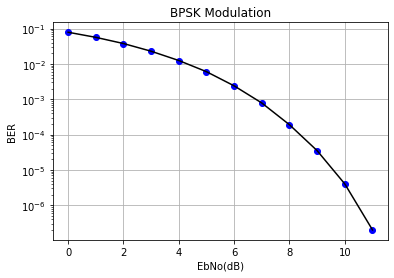

In [80]:
plt.plot(EbNodB_range, ber, 'bo', EbNodB_range, ber, 'k')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('EbNo(dB)')
plt.ylabel('BER')
plt.grid(True)
plt.title('BPSK Modulation');